In [20]:
!git clone https://github.com/acmarkes/traffic-sign-recog.git
!pip install gdown

import gdown
imgs = 'https://drive.google.com/uc?id=17an3cKGO1I2WlBPSa6zcAucL-jISSHEn'
labels = 'https://drive.google.com/uc?id=17gFHTQvU0utSNm3XMv2I8Ud4IzuqDLTl'

gdown.download(imgs, 'procImages.joblib', quiet=False)
gdown.download(labels, 'trainLabels.joblib', quiet=False)


Downloading...
From: https://drive.google.com/uc?id=17an3cKGO1I2WlBPSa6zcAucL-jISSHEn
To: /content/procImages.joblib
321MB [00:02, 131MB/s]
Downloading...
From: https://drive.google.com/uc?id=17gFHTQvU0utSNm3XMv2I8Ud4IzuqDLTl
To: /content/trainLabels.joblib
100%|██████████| 78.5k/78.5k [00:00<00:00, 15.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=17kYzgtIqwTGw5V6fDr2W05dQmVnnYjZe
To: /content/utils.py
100%|██████████| 3.02k/3.02k [00:00<00:00, 3.68MB/s]


'utils.py'

In [21]:
import utils
import joblib
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8363645444750400317
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11345264640
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1727466015588338573
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


In [25]:
procImages.shape

(39209, 32, 32, 1)

TypeError: ignored

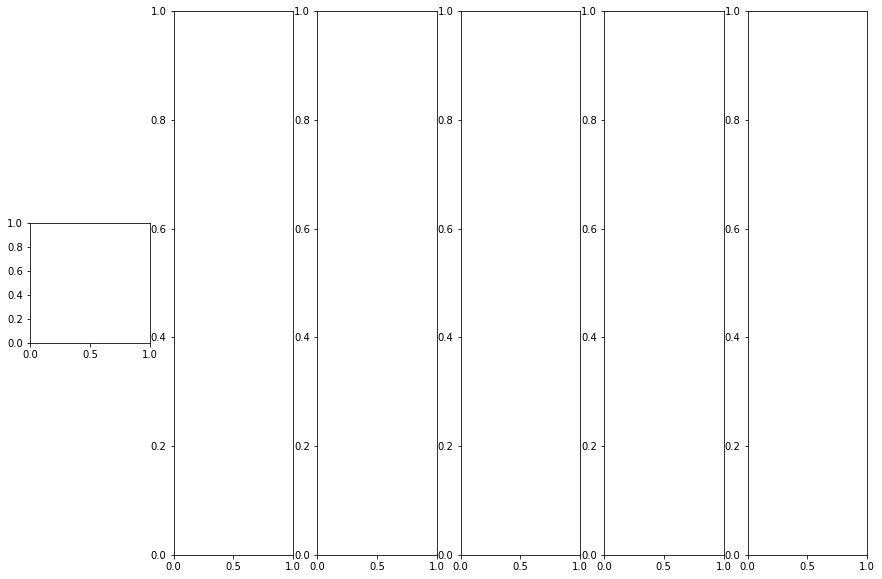

In [23]:
procImages = joblib.load('procImages.joblib')
utils.sample_images(procImages, seed_num=42)
trainLabels = joblib.load('labels.joblib')


In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test  = utils.get_dataset_partitions_tf(procImages, trainLabels)

In [ ]:
class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            keras.layers.Conv2D(filters, 3, strides=strides,
                                padding="same", use_bias=False),
            keras.layers.BatchNormalization(),
            self.activation,
            keras.layers.Conv2D(filters, 3, strides=1,
                                padding="same", use_bias=False),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                keras.layers.Conv2D(filters, 1, strides=strides,
                                    padding="same", use_bias=False),
                keras.layers.BatchNormalization()]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)


model = keras.models.Sequential()
model.add(keras.layers.Conv2D(64, 7, strides=2, input_shape=[30, 30, 3],
                              padding="same", use_bias=False))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"))
prev_filters = 64

for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters

model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(43, activation="softmax"))


In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, y_train, batch_size=32 ,epochs=3, validation_data=(X_valid,y_valid), callbacks=[callback])
score = model.evaluate(X_test,y_test)

In [ ]:
X_new = X_test[:10] # pretend we have new images
y_pred = model.predict(X_new)